In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import librosa
import librosa.display
from IPython.display import Audio 

In [3]:
paths = []
labels = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split("_")[-1]
        label = label.split(".")[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break

print('Data loaded')

Data loaded


In [4]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [5]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [6]:
df = pd.DataFrame()
df['speech'] = paths
df['labels'] = labels
df.head(5)

,speech,labels
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [7]:
df['labels'].value_counts()

labels
fear       400
angry      400
disgust    400
neutral    400
sad        400
ps         400
happy      400
Name: count, dtype: int64

In [8]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show

def spectogram(data ,sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis = 'time', y_axis= 'hz')
    plt.show

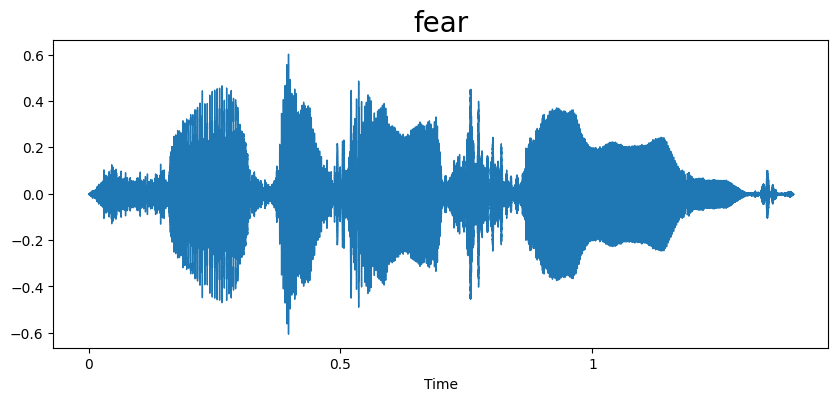

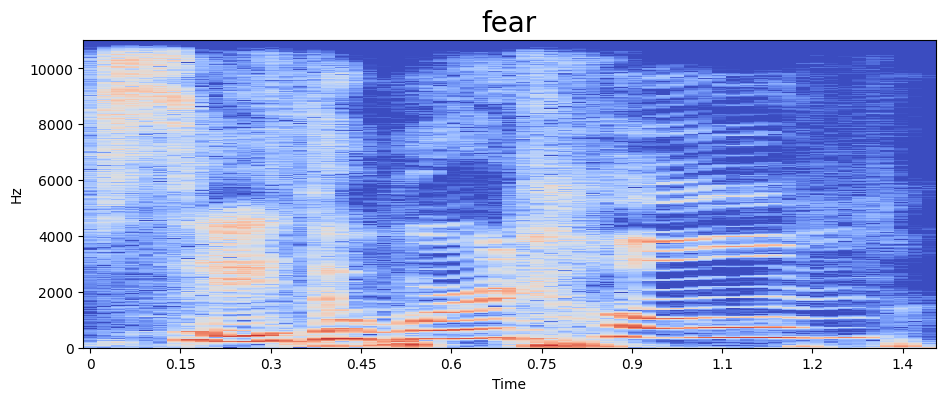

In [9]:
emotion = 'fear'
path = np.array(df['speech'][df['labels'] == emotion])[0]

data , sampling_rate = librosa.load(path)
waveplot(data, sampling_rate , emotion)
spectogram(data , sampling_rate, emotion)
Audio(path)

In [10]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [11]:
extract_mfcc(df['speech'][0])

array([-285.73727  ,   85.78295  ,   -2.1689117,   22.125532 ,
        -14.757396 ,   11.051347 ,   12.412449 ,   -3.000262 ,
          1.0844985,   11.078271 ,  -17.41966  ,   -8.093213 ,
          6.5879736,   -4.2209525,   -9.15508  ,    3.5214796,
        -13.186381 ,   14.078853 ,   19.66973  ,   22.725618 ,
         32.57464  ,   16.325033 ,   -3.8427284,    0.8962967,
        -11.239264 ,    6.653461 ,   -2.5883694,   -7.7140164,
        -10.941657 ,   -2.4007552,   -5.2812862,    4.271157 ,
        -11.202216 ,   -9.024621 ,   -3.666985 ,    4.8697433,
         -1.6027987,    2.5600514,   11.454374 ,   11.233449 ],
      dtype=float32)

In [12]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [13]:
X_mfcc

0       [-285.73727, 85.78295, -2.1689117, 22.125532, ...
1       [-348.34332, 35.193233, -3.8413284, 14.658875,...
2       [-340.11435, 53.796444, -14.267782, 20.884031,...
3       [-306.63422, 21.259708, -4.4110823, 6.4871554,...
4       [-344.7548, 46.329193, -24.171413, 19.392921, ...
                              ...                        
2795    [-374.3952, 60.864998, 0.02505877, 8.431058, -...
2796    [-313.96478, 39.847843, -5.6493053, -3.8675754...
2797    [-357.54886, 77.88605, -15.224756, 2.194633, -...
2798    [-353.1474, 101.68391, -14.175897, -12.037376,...
2799    [-389.4595, 54.042767, 1.3469982, -1.4258989, ...
Name: speech, Length: 2800, dtype: object

In [14]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [15]:
X = np.expand_dims(X, -1)

In [16]:
X.shape

(2800, 40, 1)

In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(df['labels'])
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(y_encoded.reshape(-1, 1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

2024-04-22 08:07:45.100147: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 08:07:45.100333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 08:07:45.390290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.3341 - loss: 1.6872 - val_accuracy: 0.7679 - val_loss: 0.8016
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.6940 - loss: 0.7753 - val_accuracy: 0.8638 - val_loss: 0.4454
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.8470 - loss: 0.4486 - val_accuracy: 0.9219 - val_loss: 0.2419
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9115 - loss: 0.2663 - val_accuracy: 0.9107 - val_loss: 0.2581
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9123 - loss: 0.2663 - val_accuracy: 0.9152 - val_loss: 0.2545
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.9305 - loss: 0.2097 - val_accuracy: 0.9509 - val_loss: 0.1587
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9436 - loss: 0.1824 - val_accuracy: 0.9554 - val_loss: 0.1255
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9659 - loss: 0.1202 - val_accuracy: 0.

In [22]:
y_pred = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [23]:
print(y_pred)

[[9.9998838e-01 1.6803516e-07 7.6121603e-07 ... 3.5147070e-07
  7.2036719e-06 3.1251079e-06]
 [4.1266692e-05 6.5034218e-02 1.0530781e-05 ... 8.6381355e-05
  1.5408116e-04 9.3456477e-01]
 [1.3330624e-07 1.0487576e-08 4.7494893e-07 ... 6.0074325e-13
  2.6556228e-07 1.3237816e-10]
 ...
 [9.9997765e-01 1.6358142e-07 3.8186502e-07 ... 2.0001188e-07
  2.0895443e-05 5.5354923e-07]
 [2.8980782e-07 9.9998921e-01 4.8813273e-08 ... 2.2776319e-07
  4.1881381e-06 5.3227036e-06]
 [5.8476612e-08 6.2811114e-07 4.6955652e-08 ... 3.1508344e-13
  3.7198863e-06 3.6742211e-08]]


In [24]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels = le.inverse_transform(y_pred_labels)

In [25]:
print(y_pred_labels)

['angry' 'sad' 'happy' 'angry' 'ps' 'neutral' 'sad' 'disgust' 'happy'
 'angry' 'sad' 'sad' 'happy' 'angry' 'happy' 'fear' 'disgust' 'ps' 'angry'
 'angry' 'sad' 'disgust' 'fear' 'sad' 'disgust' 'fear' 'sad' 'neutral'
 'disgust' 'sad' 'neutral' 'fear' 'disgust' 'disgust' 'happy' 'fear'
 'angry' 'neutral' 'disgust' 'ps' 'ps' 'disgust' 'happy' 'angry' 'ps'
 'fear' 'disgust' 'happy' 'sad' 'disgust' 'neutral' 'neutral' 'neutral'
 'fear' 'angry' 'angry' 'ps' 'happy' 'ps' 'neutral' 'angry' 'sad' 'ps'
 'happy' 'sad' 'happy' 'disgust' 'neutral' 'sad' 'happy' 'angry' 'fear'
 'neutral' 'sad' 'disgust' 'angry' 'happy' 'ps' 'disgust' 'fear' 'disgust'
 'fear' 'disgust' 'sad' 'ps' 'neutral' 'neutral' 'angry' 'ps' 'fear'
 'angry' 'disgust' 'angry' 'happy' 'disgust' 'ps' 'neutral' 'angry'
 'angry' 'happy' 'happy' 'sad' 'sad' 'sad' 'sad' 'disgust' 'sad' 'ps'
 'disgust' 'ps' 'neutral' 'neutral' 'ps' 'fear' 'disgust' 'fear' 'disgust'
 'fear' 'angry' 'fear' 'happy' 'ps' 'happy' 'disgust' 'happy' 'sad' 'fear

In [26]:
y_test_labels = np.argmax(y_test, axis=1)
y_test_labels = le.inverse_transform(y_test_labels)

In [27]:
print(y_test_labels)

['angry' 'disgust' 'happy' 'angry' 'ps' 'neutral' 'sad' 'disgust' 'happy'
 'angry' 'sad' 'sad' 'happy' 'angry' 'happy' 'fear' 'disgust' 'ps' 'angry'
 'angry' 'sad' 'disgust' 'fear' 'sad' 'disgust' 'fear' 'sad' 'neutral'
 'disgust' 'sad' 'neutral' 'fear' 'disgust' 'disgust' 'happy' 'fear'
 'angry' 'neutral' 'disgust' 'ps' 'ps' 'disgust' 'happy' 'angry' 'ps'
 'fear' 'disgust' 'happy' 'sad' 'disgust' 'neutral' 'neutral' 'neutral'
 'fear' 'angry' 'angry' 'ps' 'happy' 'ps' 'neutral' 'angry' 'sad' 'ps'
 'happy' 'sad' 'happy' 'disgust' 'neutral' 'sad' 'happy' 'angry' 'fear'
 'neutral' 'sad' 'disgust' 'ps' 'happy' 'ps' 'disgust' 'fear' 'disgust'
 'fear' 'disgust' 'sad' 'ps' 'neutral' 'neutral' 'angry' 'ps' 'fear'
 'angry' 'disgust' 'angry' 'happy' 'disgust' 'ps' 'neutral' 'angry'
 'angry' 'happy' 'happy' 'sad' 'sad' 'sad' 'sad' 'disgust' 'sad' 'ps'
 'disgust' 'ps' 'neutral' 'neutral' 'happy' 'fear' 'disgust' 'fear'
 'disgust' 'fear' 'angry' 'fear' 'happy' 'ps' 'happy' 'disgust' 'happy'
 'sad' 

In [28]:
from tabulate import tabulate
data = list(zip(y_test_labels, y_pred_labels))

# Print as table
print(tabulate(data, headers=['Actual', 'Predicted'], tablefmt='grid'))

+----------+-------------+
| Actual   | Predicted   |
+==========+=============+
| angry    | angry       |
+----------+-------------+
| disgust  | sad         |
+----------+-------------+
| happy    | happy       |
+----------+-------------+
| angry    | angry       |
+----------+-------------+
| ps       | ps          |
+----------+-------------+
| neutral  | neutral     |
+----------+-------------+
| sad      | sad         |
+----------+-------------+
| disgust  | disgust     |
+----------+-------------+
| happy    | happy       |
+----------+-------------+
| angry    | angry       |
+----------+-------------+
| sad      | sad         |
+----------+-------------+
| sad      | sad         |
+----------+-------------+
| happy    | happy       |
+----------+-------------+
| angry    | angry       |
+----------+-------------+
| happy    | happy       |
+----------+-------------+
| fear     | fear        |
+----------+-------------+
| disgust  | disgust     |
+----------+-------------+
|

In [29]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test_labels, y_pred_labels))

Accuracy: 0.9785714285714285
              precision    recall  f1-score   support

       angry       0.98      0.97      0.97        86
     disgust       1.00      0.93      0.97        74
        fear       1.00      1.00      1.00        89
       happy       0.98      0.98      0.98        83
     neutral       1.00      1.00      1.00        69
          ps       0.97      0.97      0.97        70
         sad       0.94      1.00      0.97        89

    accuracy                           0.98       560
   macro avg       0.98      0.98      0.98       560
weighted avg       0.98      0.98      0.98       560

